<a href="https://colab.research.google.com/github/Clinton-Nyaore/Computer-Vision/blob/main/Zindi_Spot_the_Mask_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Collection

In [1]:
import torch
import numpy as np
from torchvision import datasets, models, transforms as T
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F
from torch import nn, optim

In [2]:
import pandas as pd

path = "/content/drive/MyDrive/Data/Zindi/Spot-the-Mask-Challenge/"
train_labels = pd.read_csv(path + "train_labels.csv")
ss = pd.read_csv(path + "SampleSubmission.csv")

In [3]:
train_labels

,image,target
0,tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0
1,rxgismgsvmaayzjarbfjaljhqmpbrt.jpg,1
2,uuzshfrhkgrkolhwdvliqauzulurnz.jpg,0
3,mjspxsagzusaznvnyxgamtrlqkqklp.jpg,0
4,rlbmuajgezfiddjzlyeoupxpqubkpt.jpg,1
...,...,...
1303,hxjwafskxmlfaotwaklzuwuccsbxfu.jpg,0
1304,oyodauphffgmzmvqlykcfvmyxartok.jpg,1
1305,uppvtemhkneqggtbfubeccqjvyefiw.png,1
1306,mzjjvzkzvqmyukzsegtoktaslejcdz.jpg,0


In [4]:
ss

,image,target
0,aadawlxbmapqrblgxyzarhjasgiobu.png,0
1,abpxvdfyhaaohzcrngcucmhffwizxs.jpg,0
2,aclkjfvackiieiznzfcwienplielrj.jpg,0
3,aelkivmayxgsdjosiibfgmkvfrjvjk.jpg,0
4,aelzzshpfxerelefnkatpczktuxjln.jpg,0
...,...,...
504,zpfhbgixcctxylnihhrepjgcmjksvf.jpg,0
505,zuignwckjykxefmpubjpjefvhghaoi.jpg,0
506,zuxvwdblfwjpibjexgfglpyreqslhs.jpg,0
507,zvyajojutzgqumdjfxxkpiuuxeefyy.jpg,0


In [5]:
# You can access the image filenames and labels like this:
image_filenames = train_labels['image'].tolist()
labels = train_labels['target'].tolist()

In [6]:
import zipfile

# Specify the path to your "images.zip" file
zip_file_path = path + "images.zip"

# Specify the directory where you want to extract the images
output_dir = "/content/"

# Unzip the images
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

# 2. Data Exploration & Visualization

In [7]:
import numpy as np

# Calculate the number of samples
num_samples = len(labels)

# Calculate the number of unique classes and their distribution
unique_classes, class_counts = np.unique(labels, return_counts=True)

# Display basic statistics
print(f"Number of samples: {num_samples}")
print("Class distribution:")
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples")

Number of samples: 1308
Class distribution:
Class 0: 664 samples
Class 1: 644 samples


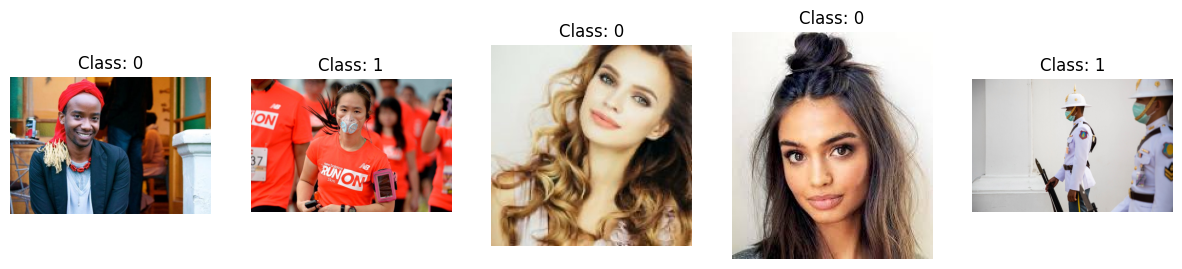

In [8]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

# Specify the directory where images were extracted
image_dir = "/content/images"

# Load a few sample images and their labels
num_samples_to_visualize = 5
sample_images = []
sample_labels = []

for i in range(num_samples_to_visualize):
    # Load and display the image
    image_filename = image_filenames[i]
    image_path = os.path.join(image_dir, image_filename)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    label = labels[i]

    sample_images.append(image)
    sample_labels.append(label)

# Visualize sample images with labels
plt.figure(figsize=(15, 5))
for i in range(num_samples_to_visualize):
    plt.subplot(1, num_samples_to_visualize, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Class: {sample_labels[i]}")
    plt.axis('off')
plt.show()

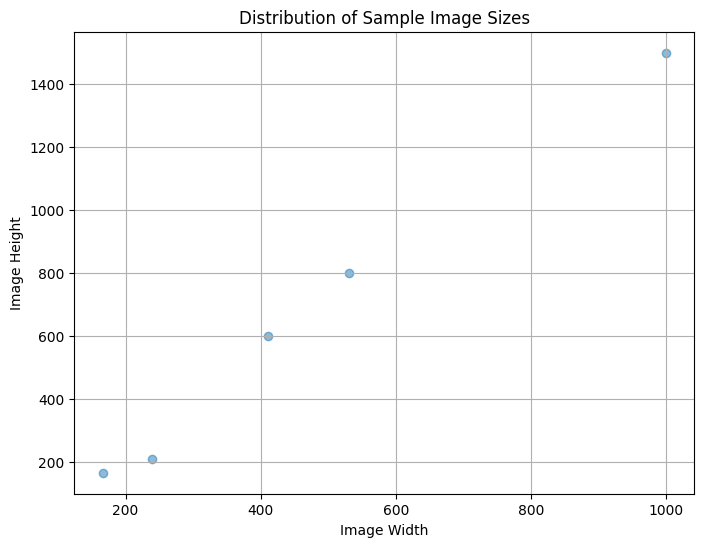

In [9]:
# Calculate and visualize the distribution of image sizes
image_sizes = [image.shape[:2] for image in sample_images]
image_sizes = np.array(image_sizes)
plt.figure(figsize=(8, 6))
plt.scatter(image_sizes[:, 0], image_sizes[:, 1], alpha=0.5)
plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.title("Distribution of Sample Image Sizes")
plt.grid(True)
plt.show()

# 3. Split the data

In [10]:
os.makedirs('/content/data/train', exist_ok=True)
os.makedirs('/content/data/test', exist_ok=True)

In [11]:
import shutil

source_image_directory = '/content/images'
train_directory = '/content/data/train'
test_directory = '/content/data/test'

# Create directories for '1' and '0' within the train and test directories
os.makedirs(os.path.join(train_directory, '1'), exist_ok=True)
os.makedirs(os.path.join(train_directory, '0'), exist_ok=True)

# Iterate through all files in the source image directory
for filename in os.listdir(source_image_directory):
    image_path = os.path.join(source_image_directory, filename)

    if os.path.exists(image_path):
      # Check if the image is listed in the CSV file
      if filename in image_filenames:
          target = train_labels[train_labels['image'] == filename]['target'].values[0]
          destination = os.path.join(train_directory, str(target), filename)
      else:
          destination = os.path.join(test_directory, filename)

      # Move the image to the appropriate directory
      shutil.move(image_path, destination)

    else: print(f"Image not found: {filename}")

print("Images have been separated into 'train' and 'test' folders.")

Images have been separated into 'train' and 'test' folders.


# 4. Load data for the model

In [12]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the data directories
train_dir = '/content/data/train'
test_dir = '/content/data/test'

# Define data transformations (you can customize these)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image data
])

# Create datasets from the image directories
train_dataset = datasets.ImageFolder(train_dir, transform=transform)

# Create data loaders for training and testing
batch_size = 32  # Set your desired batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Check the number of classes (assuming binary classification)
num_classes = len(train_dataset.classes)
print("Number of classes:", num_classes)

# Check the dataset sizes
print("Train dataset size:", len(train_dataset))

Number of classes: 2
Train dataset size: 1308


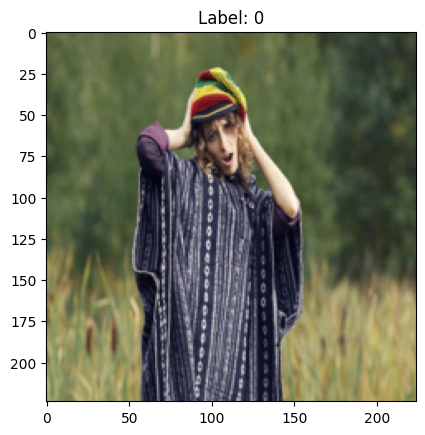

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming data_loader is already defined

# Function to denormalize a normalized image tensor (if needed)
def denormalize(image_tensor):
    # Assuming that your images were normalized with the same mean and std
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = image_tensor.permute(1, 2, 0).numpy()
    image = image * std + mean
    return np.clip(image, 0, 1)  # Clip values to the valid range [0, 1]

# Get one batch of data
for images, labels in train_loader:
    # Select one image from the batch (e.g., the first image)
    image = denormalize(images[0])  # Denormalize the image if it was previously normalized
    label = labels[0]

    # Display the image and label
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.show()
    break  # Stop after displaying one batch

# 5. Create the model

In [14]:
model = models.densenet121()
model.classifier

Linear(in_features=1024, out_features=1000, bias=True)

In [15]:
for param in model.parameters():
  param.requires_grad = False

In [16]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden = nn.Linear(1024, 500)
    self.output = nn.Linear(500, 2)

    self.dropout = nn.Dropout(p=0.2)

  def forward(self, x):
    x = x.view(x.shape[0], -1)

    x = self.dropout(F.relu(self.hidden(x)))

    x = F.softmax(self.output(x), dim=1)

    return x

In [17]:
model.classifier = Network()
model.classifier

Network(
  (hidden): Linear(in_features=1024, out_features=500, bias=True)
  (output): Linear(in_features=500, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [18]:
torch.cuda.is_available()

True

In [19]:
"""import torch
import torch.nn as nn

class SimpleCustomModel(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCustomModel, self).__init__()

        # Define layers for your model
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Define the forward pass of your model
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)  # Flatten

        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)

        return x"""

'import torch\nimport torch.nn as nn\n\nclass SimpleCustomModel(nn.Module):\n    def __init__(self, num_classes):\n        super(SimpleCustomModel, self).__init__()\n\n        # Define layers for your model\n        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)\n        self.relu1 = nn.ReLU()\n        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)\n\n        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)\n        self.relu2 = nn.ReLU()\n        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)\n\n        self.fc1 = nn.Linear(32 * 56 * 56, 128)\n        self.relu3 = nn.ReLU()\n        self.fc2 = nn.Linear(128, num_classes)\n\n    def forward(self, x):\n        # Define the forward pass of your model\n        x = self.conv1(x)\n        x = self.relu1(x)\n        x = self.pool1(x)\n\n        x = self.conv2(x)\n        x = self.relu2(x)\n        x = self.pool2(x)\n\n        x = x.view(x.size(0), 

# 6. Train and evaluate the model

In [20]:
"""import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score

# Instantiate your custom model
num_classes = 2  # Change this based on your dataset
model = SimpleCustomModel(num_classes)

# Define a loss function (e.g., CrossEntropyLoss) and an optimizer (e.g., Adam)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the device for training (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Training loop
num_epochs = 20 # Adjust the number of epochs as needed

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the device

        optimizer.zero_grad()  # Zero the gradients

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss

        loss.backward()  # Backpropagation
        optimizer.step()  # Update model weights

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

print("Training complete.")"""

'import torch\nimport torch.nn as nn\nimport torch.optim as optim\nfrom torch.utils.data import DataLoader\nfrom sklearn.metrics import roc_auc_score\n\n# Instantiate your custom model\nnum_classes = 2  # Change this based on your dataset\nmodel = SimpleCustomModel(num_classes)\n\n# Define a loss function (e.g., CrossEntropyLoss) and an optimizer (e.g., Adam)\ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.Adam(model.parameters(), lr=0.001)\n\n# Set the device for training (GPU if available, otherwise CPU)\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nprint(device)\nmodel.to(device)\n\n# Training loop\nnum_epochs = 20 # Adjust the number of epochs as needed\n\nfor epoch in range(num_epochs):\n    model.train()  # Set the model to training mode\n    running_loss = 0.0\n\n    for inputs, labels in train_loader:\n        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the device\n\n        optimizer.zero_grad()  # Zero the gradients\n\

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision import transforms, datasets

# Define device (cuda or cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pretrained model (e.g., ResNet-50)
model.to(device)

# Define data loaders (train_loader, test_loader) for your dataset

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Number of training epochs
epochs = 1

train_losses = []

for e in range(epochs):
    model.train()  # Set the model in training mode

    train_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    print(
        "Epoch : {}/{}...".format(e + 1, epochs),
        "Training loss : {:.3f}...".format(train_loss / len(train_loader))
    )

Epoch : 1/1... Training loss : 0.821...


# 7. Predictions

In [23]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import os
import pandas as pd

model.eval()  # Set the model to evaluation mode

# Define a transformation for preprocessing test images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to match the input size of your model
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])

# Define the path to the folder containing test images
test_folder = '/content/data/test'  # Replace with the path to your test image folder

# Explicitly list image filenames in the test folder
image_filenames = [os.path.join(test_folder, filename) for filename in os.listdir(test_folder)]

# Create a custom dataset for the test images without class folders
class CustomTestDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, transform=None):
        self.image_filenames = image_filenames
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = self.image_filenames[idx]
        image = Image.open(image_path).convert('RGB')  # Convert to RGB mode

        if self.transform:
            image = self.transform(image)

        return image

# Create a custom dataset for the test images
test_dataset = CustomTestDataset(image_filenames=image_filenames, transform=transform)

# Create a DataLoader for the test dataset
batch_size = 32  # Adjust as needed
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Make predictions on test images
predictions = []

for inputs in test_loader:
    with torch.no_grad():  # Disable gradient computation during inference
        inputs = inputs.to(device)
        outputs = model(inputs)

    # Assuming outputs are probabilities (e.g., after softmax)
    probabilities = torch.softmax(outputs, dim=1)
    _, predicted_class = torch.max(probabilities, dim=1)

    predictions.extend(predicted_class.tolist())

In [25]:
from keras.models import load_model
from PIL import Image, ImageOps
import numpy as np

# Load the Keras model
model = load_model("/content/keras_model.h5", compile=False)

# Define a transformation for preprocessing test images
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    size = (224, 224)
    image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)
    image_array = np.asarray(image)
    normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1
    return normalized_image_array

# Define the path to the folder containing test images
test_folder = '/content/data/test'  # Replace with the path to your test image folder

# Explicitly list image filenames in the test folder
image_filenames = [os.path.join(test_folder, filename) for filename in os.listdir(test_folder)]

# Make predictions on test images
predictions = []

for image_path in image_filenames:
    preprocessed_image = preprocess_image(image_path)
    data = np.expand_dims(preprocessed_image, axis=0)  # Add batch dimension
    prediction = model.predict(data)
    index = np.argmax(prediction)
    predictions.append(index)

# 'predictions' now contains the predicted class indices for the test images


1/1 [==============================] - 0s 22ms/step


In [24]:
ss

,image,target
0,aadawlxbmapqrblgxyzarhjasgiobu.png,0
1,abpxvdfyhaaohzcrngcucmhffwizxs.jpg,0
2,aclkjfvackiieiznzfcwienplielrj.jpg,0
3,aelkivmayxgsdjosiibfgmkvfrjvjk.jpg,0
4,aelzzshpfxerelefnkatpczktuxjln.jpg,0
...,...,...
504,zpfhbgixcctxylnihhrepjgcmjksvf.jpg,0
505,zuignwckjykxefmpubjpjefvhghaoi.jpg,0
506,zuxvwdblfwjpibjexgfglpyreqslhs.jpg,0
507,zvyajojutzgqumdjfxxkpiuuxeefyy.jpg,0


In [27]:
# Strip the file paths to retain only the filenames
stripped_filenames = [os.path.basename(filename) for filename in image_filenames]

# Create a DataFrame to store stripped filenames and predictions
data = {'image': stripped_filenames, 'target': predictions}
submission = pd.DataFrame(data)

# Display the DataFrame
submission.head()

,image,target
0,geadhikvjfcvvrtszjsxqnevbdvstr.jpg,0
1,iosikwfhnhmqdvuymkrdeatakkdryd.jpg,0
2,zdfiplzlfcwkyfucjdtkskjxjdeavq.jpg,1
3,twuombcbchukiltgyoxxovvpqidulj.jpg,0
4,utjaezxnmbadaiqjqgkmdmfdzqozqr.jpg,1


In [28]:
# Check if "mryzptvsvgrisoimspvdugeepobqkk.jpg" is in the 'image' column
filename_to_check = "mryzptvsvgrisoimspvdugeepobqkk.jpg"
is_present = filename_to_check in submission['image'].values

if is_present:
    print(f"'{filename_to_check}' is present in the 'image' column.")
else:
    print(f"'{filename_to_check}' is not present in the 'image' column.")

'mryzptvsvgrisoimspvdugeepobqkk.jpg' is present in the 'image' column.


In [29]:
# Save the submission DataFrame to a CSV file
submission.to_csv('submissions.csv', index=False)